<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/ABC_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook applies the Fokker-Planck equation derived in *Craske J. et al. 2024* to the case of a scalar concentration evolving subject to an advection diffusion equation in a triply peridioc domain. The advection diffusion equation is solved using the open source pseudo-spectral code [Dedalus](https://dedalus-project.org/) (*Burns H.J. et. al. 2020*).


**Setup**

This cell checks if Dedalus is installed and performs some other basic setup.


In [ ]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()


**Content**

First let's import everything we need to run the rest of the notebook.


In [2]:
import numpy as np
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)

Next we solve the equation for the scalar concentration
\begin{equation}
\partial_t S + \left( \boldsymbol{U} \cdot \nabla \right) S = \kappa \nabla^2 S,
\end{equation}
over the time interval $t \in [0,1]$ in a triply-periodic box $\Pi^3$, with the velocity field given by the so called ABC flow
\begin{equation}
 \boldsymbol{U} = \left( A \sin(z) + C \cos(y), B \sin(x) + A \cos(z),  C \sin(y) + B \cos(x) \right).
\end{equation}
As an initial condition we prescribe a sharp interface,
\begin{equation}
S(\boldsymbol{x},t=0) = \tanh(10(x + y + z)).
\end{equation}
*NOTE: This takes about 3 minutes to run.*

In [ ]:
# Parameters
κ     = 0.1;  # Equivalent to Peclet number
A,B,C = 1,1,1;
Nx    = 32;   # This can be reduced but it will increase the noise in the histogram
stop_sim_time = .25
timestep = 1e-03

# Domain
coords = d3.CartesianCoordinates('x','y','z')
dist   = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)
ybasis = d3.RealFourier(coords['y'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)
zbasis = d3.RealFourier(coords['z'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)

# Fields
S = dist.Field(name='S', bases=(xbasis,ybasis,zbasis))
U = dist.VectorField(coords, name='U', bases=(xbasis,ybasis,zbasis))
x,y,z = dist.local_grids(xbasis,ybasis,zbasis)

# ABC flow
U['g'][0] = A*np.sin(z) + C*np.cos(y);
U['g'][1] = B*np.sin(x) + A*np.cos(z);
U['g'][2] = C*np.sin(y) + B*np.cos(x);

# Initial condition
S['g']    = np.tanh(10*(x + y + z))

# Problem
grad_S  = d3.grad(S)
problem = d3.IVP([S], namespace=locals())
problem.add_equation("dt(S) - κ*div(grad_S) = -U@grad(S)") #

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=100)
flow.add_property(d3.Integrate(S**2)         , name='<S^2>' )
flow.add_property(d3.Integrate(grad_S@grad_S), name='<dS^2>')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 100 == 0:

            S2_avg = flow.grid_average('<S^2>')
            dS_avg = flow.grid_average('<dS^2>' )

            logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
            logger.info('<S^2>=%f, <dS^2>    =%f'%(S2_avg,dS_avg))

        # Capture the last 5 snapshots
        if  solver.iteration == int(stop_sim_time/timestep) - 5:
            snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
            snapshots.add_task(S,      layout='g',name='Scalar',scales=3/2)
            snapshots.add_task(grad_S, layout='g',name='grad_S',scales=3/2)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

The Fokker-Planck equation describing the *global scalar concentration* is given by
\begin{equation}
\frac{\partial }{ \partial t} f = \frac{\partial^2 }{ \partial s^2} \left( \mathbb{D}^{(2)} f \right), \quad \text{where} \quad \mathbb{D}^{(2)} = \mathbb{E}_{S_t}[-\kappa |\nabla S|^2],
\end{equation}
and $f(s;t)$ is the global probability density function. This density describes the probability of finding a scalar concentration $s$ at a time $t$ in the triply periodic domain $\Pi^3$. Having time integrated the transport equation for the solute concentration we now have a set of snapshots $S(\boldsymbol{x},t)$ at discrete time intervals $t_n$. Using this data we now calculate the terms in this equation by loading the numerical snapshots saved below.

In [4]:
# Data loading
file   = h5py.File('./snapshots/snapshots_s1.h5', mode='r')
times  = file['tasks/Scalar'].dims[0][0][:]
x_data = file['tasks/Scalar'].dims[1][0][:]
y_data = file['tasks/Scalar'].dims[2][0][:]
z_data = file['tasks/Scalar'].dims[3][0][:]

S_data   = file['tasks/Scalar'][:,...]
dSx_data = file['tasks/grad_S'][:,0,...]
dSy_data = file['tasks/grad_S'][:,1,...]
dSz_data = file['tasks/grad_S'][:,2,...]
dS2_data = dSx_data**2 + dSy_data**2 + dSz_data**2;

To evaluate the left hand side we estimate the pdf $f$ (using a histogram) and then compute its time derivative $\partial_t f$ using central differences.

In [5]:
N_bins = 256

# PDF f_s
f_np2,s = np.histogram(S_data[-1,...].flatten(),bins=N_bins,density=True); # n + 2 (-1)
f_np1,s = np.histogram(S_data[-2,...].flatten(),bins=N_bins,density=True); # n + 1 (-2)

f_nm1,s = np.histogram(S_data[-4,...].flatten(),bins=N_bins,density=True); # n - 1 (-4)
f_nm2,s = np.histogram(S_data[-5,...].flatten(),bins=N_bins,density=True); # n - 2 (-5)

s       = 0.5*(s[1:] + s[:-1]); ds = s[1] - s[0];

# Time derivate df_s/dt
dt   = times[-1] - times[-2];
dfdt = (-1./12.)*f_np2 + (2./3.)*f_np1 - (2./3.)*f_nm1 + (1./12.)*f_nm2;
dfdt /=dt;

To calculate the right hand side we first compute the coefficient $\mathbb{D}^{(2)}$, using the fact that the conditional expectation can be re-expressed in terms of its joint density
\begin{equation}
\mathbb{D}^{(2)} \equiv \mathbb{E}_{S_t}[-\kappa |\nabla S|^2] = - \kappa \int \frac{\phi f(\phi, s, t)}{f(s,t)} d \phi, \quad \text{where} \quad \phi = |\nabla S|^2.
\end{equation}
This coefficent is calculated below by estimating the joint density using a histogram and then evaluating the integral. Subsequently we create the derivative operator $L = \partial^2_s$ using central differences.

In [6]:
# Expectation
f_SΦ,s,φ = np.histogram2d(S_data[-3,...].flatten(), dS2_data[-3,...].flatten(),bins=N_bins,density=True) # n (-3)
φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
s = .5*(s[1:]+s[:-1]); ds = s[1] - s[0];
f_S =  np.sum(  f_SΦ,axis=1)*dφ     # f_S(s)
E   = (np.sum(φ*f_SΦ,axis=1)*dφ)/f_S; # E{Φ|S} = int_φ f_Φ|S(φ|s)*φ dφ
D   = -κ*E

# Derivative
N = len(s)
L = np.zeros((N,N))
for i in range(N):
  L[i,i] = -2.
  if i < N-1:
    L[i,i+1] = 1
  if i > 1:
    L[i,i-1] = 1
L   *= 1./(ds**2);

**Results**

Having computed the terms appearing in the left and right hand sides of the Fokker-Planck for this advection diffusion problem we can now investigate their form as well as validating that the left and right hand sides are equal. In the figure below we plot (a) the scalar field $S(\boldsymbol{x},t_n)$, (b) the density and the diffusion coefficient $f, \mathbb{D}^{(2)}$ and (c) the right and left hand sides of the Fokker-Planck equation.

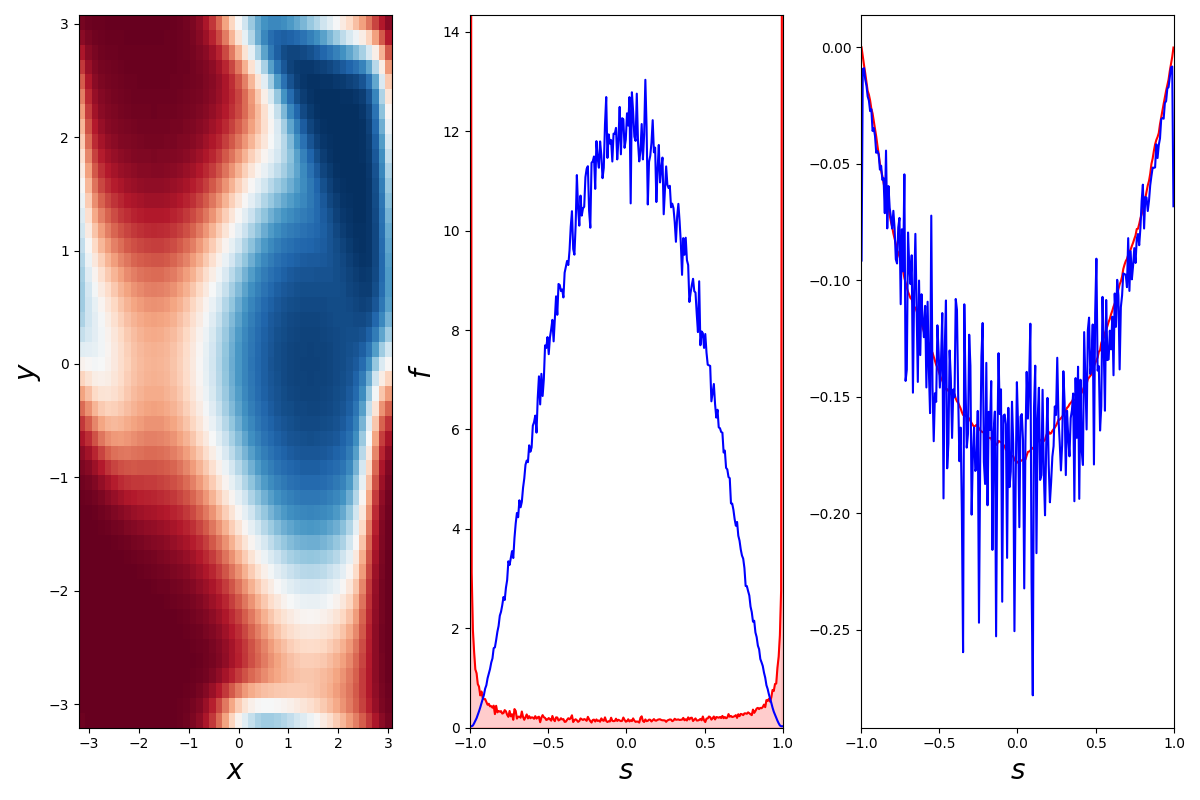

In [13]:
import matplotlib.pyplot as plt
%matplotlib widget

fig, axs = plt.subplots(1,3,figsize=(12,8))

axs[0].pcolormesh(x_data,y_data,S_data[-1,:,:,0],cmap='RdBu',norm='linear')
axs[0].set_ylabel(r'$y$',fontsize=20)
axs[0].set_xlabel(r'$x$',fontsize=20)

axs[1].plot(s,f_S,'r')
axs[1].fill_between(x=s,y1=f_S,color= "r",alpha= 0.2)
axs[1].plot(s,E  ,'b')
axs[1].set_ylabel(r'$f$',fontsize=20)
axs[1].set_xlabel(r'$s$',fontsize=20)
axs[1].set_xlim([-1,1])
axs[1].set_ylim([0.,1.1*np.max(E)])

LHS = np.linalg.solve(L,dfdt)
RHS = D*f_S
axs[2].plot(s,LHS,'r')
axs[2].plot(s,RHS,'b')
axs[2].set_xlabel(r'$s$',fontsize=20)
axs[2].set_xlim([-1,1])


plt.tight_layout()
plt.savefig('ABC_Flow.png',dpi=200)
plt.show()